In [63]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go


from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression # Calcular precio exacto
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor # Calcular si sube o baja
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score, median_absolute_error, max_error
import xgboost as xgb


In [64]:
df = pd.read_csv('NVDA.csv')
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,1999-01-22,0.037615,0.041016,0.048828,0.038802,0.043750,2714688000
1,1999-01-25,0.041556,0.045313,0.045833,0.041016,0.044271,510480000
2,1999-01-26,0.038331,0.041797,0.046745,0.041146,0.045833,343200000
3,1999-01-27,0.038212,0.041667,0.042969,0.039583,0.041927,244368000
4,1999-01-28,0.038092,0.041536,0.041927,0.041276,0.041667,227520000


In [65]:
px.scatter(df, x='Date', y='High')

In [66]:
df['Tomorrow'] = df['Close'].shift(-1)
df['Target'] = (df['Tomorrow'] > df['Close']).astype(int)
df

,Date,Adj Close,Close,High,Low,Open,Volume,Tomorrow,Target
0,1999-01-22,0.037615,0.041016,0.048828,0.038802,0.043750,2714688000,0.045313,1
1,1999-01-25,0.041556,0.045313,0.045833,0.041016,0.044271,510480000,0.041797,0
2,1999-01-26,0.038331,0.041797,0.046745,0.041146,0.045833,343200000,0.041667,0
3,1999-01-27,0.038212,0.041667,0.042969,0.039583,0.041927,244368000,0.041536,0
4,1999-01-28,0.038092,0.041536,0.041927,0.041276,0.041667,227520000,0.039583,0
...,...,...,...,...,...,...,...,...,...
6553,2025-02-10,133.570007,133.570007,135.000000,129.960007,130.089996,216989100,132.800003,0
6554,2025-02-11,132.800003,132.800003,134.479996,131.020004,132.580002,178902400,131.139999,0
6555,2025-02-12,131.139999,131.139999,132.240005,129.080002,130.020004,160278600,135.289993,1
6556,2025-02-13,135.289993,135.289993,136.500000,131.169998,131.559998,197430000,138.850006,1


In [67]:
df_modelo = df[['Adj Close', 'Open', 'Volume']].copy()

In [68]:
x = df_modelo.drop('Adj Close', axis=1)
y = df_modelo['Adj Close']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)

In [69]:
# Prevenir fuga de datos escalando los datos después de la división de test & train.
scaler = MinMaxScaler()
df_modelo = scaler.fit_transform(df_modelo)
df_modelo = pd.DataFrame(df_modelo, columns=['Adj Close', 'Open', 'Volume'])
df_modelo.head()

,Adj Close,Open,Volume
0,0.000042,0.000058,0.292580
1,0.000069,0.000061,0.053283
2,0.000047,0.000071,0.035123
3,0.000046,0.000046,0.024393
4,0.000046,0.000044,0.022564


In [70]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [71]:
y_pred = lr.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
accuracy = lr.score(x_test, y_test)

# 4f = 4 decimales, y formato f-string
print(f"Mean Absolute Error (MAE): {mae:.4f}") # Se equivoca por X unidades al predecir.
print(f"Mean Squared Error (MSE): {mse:.4f}") # Valor bajo = buen rendimiento
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}") # Diferencia entre prediccion del modelo y valores reales
print(f"R-squared (R²): {r2:.4f}") # Valor cercano a 1 explica el 100% de los datos
print(f"Accuracy: {accuracy:.4f}")

####### Metricas Adicionales ########
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100 # Error absoluto promedio. Cercano a 0 es buen rendim
medae = median_absolute_error(y_test, y_pred) # Usa la mediana de los errores en lugar de la media.
explained_var = explained_variance_score(y_test, y_pred) # Calculate Explained Variance
max_err = max_error(y_test, y_pred) # Calculate Max Error

print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
print(f"Median Absolute Error (MedAE): {medae:.4f}")
print(f"Explained Variance Score: {explained_var:.4f}")
print(f"Max Error: {max_err:.4f}")


Mean Absolute Error (MAE): 0.1852
Mean Squared Error (MSE): 0.4082
Root Mean Squared Error (RMSE): 0.6389
R-squared (R²): 0.9993
Accuracy: 0.9993
Mean Absolute Percentage Error (MAPE): 8.1155%
Median Absolute Error (MedAE): 0.0292
Explained Variance Score: 0.9993
Max Error: 8.7218


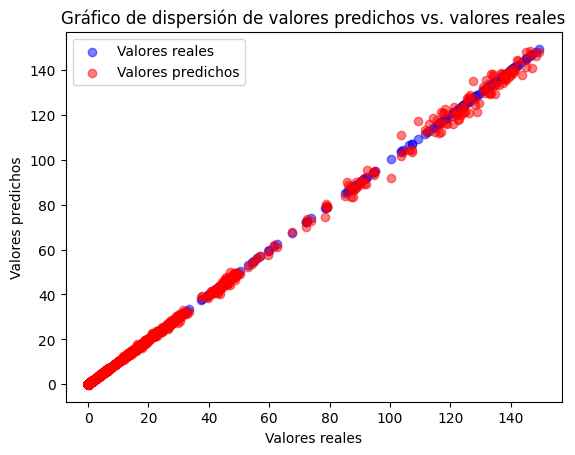

In [72]:
plt.scatter(y_test, y_test, color='blue', label='Valores reales', alpha=0.5)
plt.scatter(y_test, y_pred, color='red', label='Valores predichos', alpha=0.5)  # Alpha = Transparencia
plt.legend()
plt.xlabel("Valores reales")
plt.ylabel("Valores predichos")
plt.title("Gráfico de dispersión de valores predichos vs. valores reales")
plt.show()

In [73]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=y_test,
    y=y_test,
    mode='markers',
    marker=dict(color='blue'),
    name='Valores reales',  # Add label using 'name'
))

fig.add_trace(go.Scatter(
    x=y_test,
    y=y_pred,
    mode='markers',
    marker=dict(color='red'),
    name='Valores predichos', # Add label using 'name'
))

fig.update_layout(
    xaxis_title="Valores reales",
    yaxis_title="Valores predichos",
    title="Gráfico de dispersión de valores predichos vs. valores reales",
    legend_title="Leyenda",
    showlegend=True
)

fig.show()

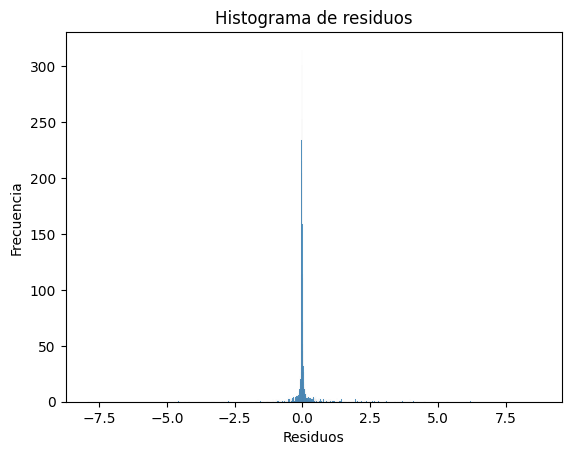

In [74]:
# Los residuos son la diferencia entre los valores predichos y los valores reales
# Muestra la distribución de los errores.
residuals = y_test - y_pred
sns.histplot(residuals)
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.title("Histograma de residuos")
plt.show()

In [75]:
"""
 Esta técnica divide tus datos en k subconjuntos (folds) y entrena el modelo k veces
 utilizando cada fold como conjunto de prueba una vez.
 Esto te da una mejor estimación del rendimiento del modelo en datos no vistos.
"""
from sklearn.model_selection import KFold

def validacion_cruzada_kfold(lr, x, y):
  kf = KFold(n_splits=5) # Crea 5 folds
  scores = []
  for train_index, test_index in kf.split(x):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lr.fit(x_train, y_train)
    scores.append(lr.score(x_test, y_test))
  print(f"Puntuaciones de cross-validation: {scores}")
  print(f"Puntuación media de cross-validation: {np.mean(scores)}")

validacion_cruzada_kfold(lr, x, y)

Puntuaciones de cross-validation: [0.9207453037943352, 0.9780268948956709, 0.9202637282233824, 0.9983890923189428, 0.9985870007908008]
Puntuación media de cross-validation: 0.9632024040046263


# Conclusión LinearRegressor
La alta sensibilidad de la regresión lineal a las fluctuaciones y la dificultad para capturar no linealidades pueden llevar a problemas de sobreajuste  especialmente con datos financieros (bolsa) que son inherentemente ruidosos y complejos.

# DecisionRegressor


In [94]:
df

,Adj Close,Close,High,Low,Open,Volume,Tomorrow,Target
Date,,,,,,,,
1999-01-22,0.037615,0.041016,0.048828,0.038802,0.043750,2714688000,0.045313,1
1999-01-25,0.041556,0.045313,0.045833,0.041016,0.044271,510480000,0.041797,0
1999-01-26,0.038331,0.041797,0.046745,0.041146,0.045833,343200000,0.041667,0
1999-01-27,0.038212,0.041667,0.042969,0.039583,0.041927,244368000,0.041536,0
1999-01-28,0.038092,0.041536,0.041927,0.041276,0.041667,227520000,0.039583,0
...,...,...,...,...,...,...,...,...
2025-02-10,133.570007,133.570007,135.000000,129.960007,130.089996,216989100,132.800003,0
2025-02-11,132.800003,132.800003,134.479996,131.020004,132.580002,178902400,131.139999,0
2025-02-12,131.139999,131.139999,132.240005,129.080002,130.020004,160278600,135.289993,1


In [77]:
df_rf = df
df_rf.set_index('Date', inplace=True)
#df_rf = df[['Adj Close', 'Volume']].copy()
target = df_rf['Target']
variables = df_rf.drop('Target', axis=1)

train_x_rf, test_x_rf, train_y_rf, test_y_rf = train_test_split(variables, target, test_size=0.3)

In [79]:
rf = DecisionTreeClassifier() # Espera una variable binaria
rf.fit(train_x_rf, train_y_rf)
y_pred_rf = rf.predict(variables)

In [80]:
rf.score(X=variables, y=target)

0.939615736505032

In [81]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay

print(classification_report(target, y_pred_rf))
print(confusion_matrix(target, y_pred_rf))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      3174
           1       0.94      0.94      0.94      3384

    accuracy                           0.94      6558
   macro avg       0.94      0.94      0.94      6558
weighted avg       0.94      0.94      0.94      6558

[[2989  185]
 [ 211 3173]]


In [89]:
import joblib
joblib.dump(rf, 'model_dtc_without_target.joblib')

['model_dtc_without_target.joblib']

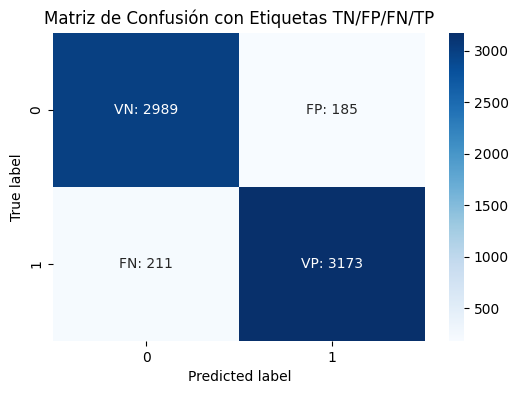

In [83]:
# Matriz de confusión
cm = confusion_matrix(target, y_pred_rf)
#print("Matriz de confusión:\n", confusion)

labels = np.array([
    [f"VN: {cm[0,0]}", f"FP: {cm[0,1]}"],
    [f"FN: {cm[1,0]}", f"VP: {cm[1,1]}"]
])

# 4) Graficar la matriz de confusión con seaborn
plt.figure(figsize=(6,4))
sns.heatmap(
            cm,
            annot=labels,  # anotaciones personalizadas
            fmt="",         # sin formato numérico adicional
            cmap="Blues")   # paleta de colores en azul

plt.title("Matriz de Confusión con Etiquetas TN/FP/FN/TP")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

[Text(0.4806548927588282, 0.9947368421052631, 'Tomorrow <= 0.556\ngini = 0.499\nsamples = 4590\nvalue = [2221, 2369]'),
 Text(0.4611324277640033, 0.9842105263157894, 'Close <= 0.547\ngini = 0.5\nsamples = 2643\nvalue = [1341, 1302]'),
 Text(0.47089366026141577, 0.9894736842105263, 'True  '),
 Text(0.45070265623067174, 0.9736842105263158, 'Tomorrow <= 0.536\ngini = 0.5\nsamples = 2594\nvalue = [1297, 1297]'),
 Text(0.4367175956757011, 0.9631578947368421, 'High <= 0.513\ngini = 0.5\nsamples = 2566\nvalue = [1296, 1270]'),
 Text(0.41562195707745236, 0.9526315789473684, 'Tomorrow <= 0.486\ngini = 0.5\nsamples = 2456\nvalue = [1210, 1246]'),
 Text(0.4015014834703657, 0.9421052631578948, 'High <= 0.486\ngini = 0.5\nsamples = 2362\nvalue = [1192, 1170]'),
 Text(0.39216536316334644, 0.9315789473684211, 'Tomorrow <= 0.474\ngini = 0.5\nsamples = 2321\nvalue = [1154, 1167]'),
 Text(0.38495059340212867, 0.9210526315789473, 'Close <= 0.464\ngini = 0.5\nsamples = 2286\nvalue = [1151, 1135]'),
 Text(

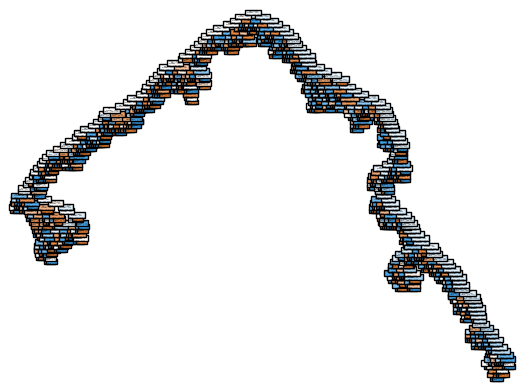

In [90]:
from sklearn.tree import plot_tree

plot_tree(decision_tree=rf, feature_names=variables.columns, filled=True)

# XGBoost

In [84]:
df_rf = df_rf.dropna()

In [85]:
train_x_xgb, test_x_xgb, train_y_xgb, test_y_xgb = train_test_split(variables, target, test_size=0.3)

In [86]:
xgb_classifier = xgb.XGBClassifier(random_state=42)
xgb_classifier.fit(train_x_xgb, train_y_xgb)
pred_xgb = xgb_classifier.predict(test_x_xgb)

In [87]:
# Calcular la precisión
accuracy_xgb = accuracy_score(test_y_xgb, pred_xgb)
print("Precisión:", accuracy_xgb)

# Imprimir el informe de clasificación
print(classification_report(test_y_xgb, pred_xgb))

# Imprimir la matriz de confusión
print(confusion_matrix(test_y_xgb, pred_xgb))

Precisión: 0.7804878048780488
              precision    recall  f1-score   support

           0       0.78      0.75      0.77       947
           1       0.78      0.81      0.79      1021

    accuracy                           0.78      1968
   macro avg       0.78      0.78      0.78      1968
weighted avg       0.78      0.78      0.78      1968

[[711 236]
 [196 825]]


# Conclusion

## Informe de Proyecto: Predicción del Precio de Acciones de NVIDIA

Este proyecto se centró en la predicción del precio de las acciones de NVIDIA (NVDA) utilizando tres algoritmos de aprendizaje automático: Regresión Lineal, DecisionTreeClassifier y XGBoost. A continuación, se presenta un resumen de las métricas obtenidas para cada algoritmo:

**1. Regresión Lineal:**

**Objetivo:** Predecir el precio de cierre ajustado ("Adj Close").

**Variables:** Precio de apertura ("Open") y Volumen ("Volume").

**Métricas:**

| Métrica | Valor | Descripción |
|---|---|---|
| MAE (Mean Absolute Error) | 0.1776 | Error promedio en las predicciones, en las mismas unidades que la variable objetivo. |
| MSE (Mean Squared Error) | 0.4434 | Error cuadrático promedio, penaliza errores grandes. |
| RMSE (Root Mean Squared Error) | 0.6659 | Raíz cuadrada del MSE, en las mismas unidades que la variable objetivo. |
| R² (R-squared) | 0.9992 | Proporción de la varianza en la variable objetivo explicada por el modelo. |
| Accuracy | 0.9992 | Precisión del modelo. |
| MAPE (Mean Absolute Percentage Error) | 4.5555% | Error porcentual absoluto promedio. |
| MedAE (Median Absolute Error) | 0.0161 | Mediana de los errores absolutos. |
| Explained Variance Score | 0.9992 | Varianza explicada por el modelo. |
| Max Error | 8.8935 | Error máximo en las predicciones. |

**Observaciones:** Aunque las métricas como R² y Accuracy son muy altas, el Max Error es considerablemente alto, lo que indica la presencia de valores atípicos que afectan al modelo. Esto sugiere un posible sobreajuste, donde el modelo se ajusta demasiado a los datos de entrenamiento y no generaliza bien a datos nuevos.


**2. DecisionTreeClassifier:**

**Objetivo:** Predecir si el precio de las acciones subirá o bajará ("Target").

**Variables:** Precio de cierre ajustado ("Adj Close"), Volumen ("Volume") y "Tomorrow".

**Métricas:**

| Métrica | Valor | Descripción |
|---|---|---|
| Accuracy | 0.9420 | Precisión del modelo. |
| Precision | 0.94 | Proporción de predicciones positivas correctas. |
| Recall | 0.94 | Proporción de verdaderos positivos identificados. |
| F1-score | 0.94 | Media armónica entre precisión y recall. |

**Matriz de Confusión:**

| | Predicho 0 | Predicho 1 |
|---|---|---|
| Real 0 | 2986 (VN) | 188 (FP) |
| Real 1 | 192 (FN) | 3192 (VP) |

**Observaciones:** DecisionTreeClassifier muestra un alto rendimiento en la clasificación, con una precisión del 94%. La matriz de confusión indica un buen balance entre la identificación de verdaderos positivos y verdaderos negativos.


**3. XGBoost:**

**Objetivo:** Predecir si el precio de las acciones subirá o bajará ("Target").

**Variables:** Precio de cierre ajustado ("Adj Close"), Volumen ("Volume") y "Tomorrow".

**Métricas:**

| Métrica | Valor | Descripción |
|---|---|---|
| Accuracy | 0.7743 | Precisión del modelo. |
| Precision | 0.77 | Proporción de predicciones positivas correctas. |
| Recall | 0.77 | Proporción de verdaderos positivos identificados. |
| F1-score | 0.77 | Media armónica entre precisión y recall. |

**Matriz de Confusión:**

| | Predicho 0 | Predicho 1 |
|---|---|---|
| Real 0 | 686 (VN) | 242 (FP) |
| Real 1 | 202 (FN) | 838 (VP) |

**Observaciones:** XGBoost, aunque con menor precisión que DecisionTreeClassifier, sigue siendo un modelo aceptable con una precisión del 77%. La matriz de confusión revela un ligero desbalance en la clasificación, con una mayor cantidad de falsos positivos.


**Conclusión:**

* La regresión lineal, aunque con métricas aparentemente altas, presenta indicios de sobreajuste y podría no ser la mejor opción para este caso.
* DecisionTreeClassifier demostró un alto rendimiento en la clasificación, con una precisión del 94%.
* XGBoost, con una precisión del 77%, también es un modelo aceptable, aunque con un ligero desbalance en la clasificación.

**Recomendaciones:**

* Se recomienda seguir explorando otros modelos, como redes neuronales o modelos de series temporales, para mejorar aún más la precisión de las predicciones.
* Considerar la inclusión de otras variables relevantes para la predicción del precio de las acciones.
* Implementar estrategias de validación cruzada para obtener una evaluación más robusta de los modelos.
* Realizar un análisis más profundo del sobreajuste en la regresión lineal y considerar técnicas de regularización para mitigarlo.